In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

import tqdm
tqdm.tqdm.pandas()

In [4]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack
from rgnn_at_scale.models import GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.helper.utils import accuracy

## Config
**General config:**

In [5]:
datasets = ['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv']
search_space_sizes = [1_000_000, 1_000_000, 2_500_000, 10_000_000]
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
victim_param_list = [
    {
        'n_filters': 64,d
        'dropout': 0.5
    },
    {
        'n_filters': 64,
        'dropout': 0.5
    },
    {
        'n_filters': 64,
        'dropout': 0.5
    },
    {
        'n_filters': [256, 256],
        'dropout': 0.5,
        'with_batchnorm': True,
    }
]
train_params = {
    'lr': 1e-2,
    'weight_decay': 0,
    'patience': 300,
    'max_epochs': 3000
}
attack_params = {
    'keep_heuristic': 'WeightOnly',
    'loss_type': 'tanhMargin',
    'fine_tune_epochs': 0,
    'with_early_stropping': False
}
epsilons = [0.001, 0.01, 0.1]
display_steps = 10

y_kde_max = 7.5

make_undirected_options = [True, False]
loss_types = ['CE', 'CW', 'tanhMargin']

torch.manual_seed(seed)
np.random.seed(seed)

**Config for plotting:**

In [6]:
bins = 6

assert bins % 2 == 0, 'Only an even number of bins supported'

x_0 = 4
x_1 = 2
x_2 = 0

bar_width = 0.8

neg_colormap = plt.get_cmap('Oranges')
pos_colormap = plt.get_cmap('Blues')

colors = (
    [neg_colormap((bins / 2 - i) / bins) for i in range(bins // 2)]
    + [pos_colormap((bins / 2 - i) / bins) for i in reversed(range(bins // 2))]
)

fig_width = 0.35
fig_ratio_yx = 0.6

## Attack and Generate Plots

cora_ml 1000000 {'n_filters': 64, 'dropout': 0.5} False


Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 2/400 [00:00<00:22, 17.51it/s]

Clean accuracy: 0.64861661195755
cora_ml False 0.001 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757807493209839 Accuracy: 64.664 %



  6%|▌         | 24/400 [00:01<00:19, 19.76it/s]


Epoch: 20 Loss: 1.0968644618988037 Accuracy: 64.862 %



 11%|█         | 44/400 [00:02<00:17, 19.92it/s]


Epoch: 40 Loss: 1.0991705656051636 Accuracy: 64.862 %



 16%|█▌        | 64/400 [00:03<00:16, 19.85it/s]


Epoch: 60 Loss: 1.1001869440078735 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:15, 19.83it/s]


Epoch: 80 Loss: 1.100814938545227 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:14, 19.76it/s]


Epoch: 100 Loss: 1.1012609004974365 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:13, 19.81it/s]


Epoch: 120 Loss: 1.1016108989715576 Accuracy: 64.862 %



 36%|███▌      | 143/400 [00:07<00:12, 19.87it/s]


Epoch: 140 Loss: 1.1018859148025513 Accuracy: 64.862 %



 41%|████      | 164/400 [00:08<00:11, 19.78it/s]


Epoch: 160 Loss: 1.1021229028701782 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:09<00:10, 19.85it/s]


Epoch: 180 Loss: 1.1023218631744385 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:10<00:09, 19.76it/s]


Epoch: 200 Loss: 1.1024671792984009 Accuracy: 64.862 %



 56%|█████▌    | 223/400 [00:11<00:08, 19.84it/s]


Epoch: 220 Loss: 1.1025961637496948 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:12<00:07, 19.77it/s]


Epoch: 240 Loss: 1.1026935577392578 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:13<00:06, 19.71it/s]


Epoch: 260 Loss: 1.1027884483337402 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:14<00:05, 19.83it/s]


Epoch: 280 Loss: 1.1028755903244019 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:15<00:04, 19.85it/s]


Epoch: 300 Loss: 1.1029558181762695 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:16<00:03, 19.79it/s]


Epoch: 320 Loss: 1.103026032447815 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:17<00:02, 19.64it/s]


Epoch: 340 Loss: 1.1030893325805664 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:18<00:01, 19.66it/s]


Epoch: 360 Loss: 1.1031454801559448 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:19<00:00, 19.82it/s]


Epoch: 380 Loss: 1.1031917333602905 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6482213139533997
cora_ml False 0.001 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %


Epoch: 0 Loss: -2.041541337966919 Accuracy: 64.901 %



  6%|▌         | 24/400 [00:01<00:19, 19.54it/s]


Epoch: 20 Loss: -1.9930001497268677 Accuracy: 64.862 %



 11%|█         | 44/400 [00:02<00:18, 19.53it/s]


Epoch: 40 Loss: -1.9921762943267822 Accuracy: 64.862 %



 16%|█▌        | 64/400 [00:03<00:18, 18.64it/s]


Epoch: 60 Loss: -1.9917796850204468 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:17, 18.27it/s]


Epoch: 80 Loss: -1.9915642738342285 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:16, 18.45it/s]


Epoch: 100 Loss: -1.9913930892944336 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:15, 18.37it/s]


Epoch: 120 Loss: -1.991247534751892 Accuracy: 64.862 %



 36%|███▌      | 144/400 [00:07<00:13, 18.35it/s]


Epoch: 140 Loss: -1.9912128448486328 Accuracy: 64.862 %



 41%|████      | 164/400 [00:08<00:12, 18.39it/s]


Epoch: 160 Loss: -1.9911638498306274 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:09<00:11, 18.49it/s]


Epoch: 180 Loss: -1.9910407066345215 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:10<00:10, 18.61it/s]


Epoch: 200 Loss: -1.990962266921997 Accuracy: 64.862 %



 56%|█████▌    | 224/400 [00:11<00:09, 18.56it/s]


Epoch: 220 Loss: -1.9909600019454956 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:13<00:08, 18.60it/s]


Epoch: 240 Loss: -1.9908843040466309 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.63it/s]


Epoch: 260 Loss: -1.9908159971237183 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:15<00:06, 18.58it/s]


Epoch: 280 Loss: -1.9908225536346436 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.51it/s]


Epoch: 300 Loss: -1.9907251596450806 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:17<00:04, 18.44it/s]


Epoch: 320 Loss: -1.9907104969024658 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.39it/s]


Epoch: 340 Loss: -1.990695834159851 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:19<00:01, 18.38it/s]


Epoch: 360 Loss: -1.9906816482543945 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:20<00:00, 18.30it/s]


Epoch: 380 Loss: -1.9906376600265503 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6458497643470764
cora_ml False 0.001 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:21, 18.44it/s]


Epoch: 0 Loss: -0.2961744964122772 Accuracy: 64.190 %



  6%|▌         | 24/400 [00:01<00:20, 18.42it/s]


Epoch: 20 Loss: -0.2760683298110962 Accuracy: 62.451 %



 11%|█         | 44/400 [00:02<00:19, 18.22it/s]


Epoch: 40 Loss: -0.27436119318008423 Accuracy: 62.174 %



 16%|█▌        | 64/400 [00:03<00:18, 18.50it/s]


Epoch: 60 Loss: -0.2736821174621582 Accuracy: 61.897 %



 21%|██        | 84/400 [00:04<00:17, 18.46it/s]


Epoch: 80 Loss: -0.2732928991317749 Accuracy: 61.937 %



 26%|██▌       | 104/400 [00:05<00:16, 18.50it/s]


Epoch: 100 Loss: -0.2730417847633362 Accuracy: 61.937 %



 31%|███       | 124/400 [00:06<00:14, 18.50it/s]


Epoch: 120 Loss: -0.27286216616630554 Accuracy: 61.976 %



 36%|███▌      | 144/400 [00:07<00:13, 18.44it/s]


Epoch: 140 Loss: -0.2727266848087311 Accuracy: 61.858 %



 41%|████      | 164/400 [00:08<00:12, 18.47it/s]


Epoch: 160 Loss: -0.27264389395713806 Accuracy: 61.858 %



 46%|████▌     | 184/400 [00:09<00:11, 18.45it/s]


Epoch: 180 Loss: -0.27255430817604065 Accuracy: 61.897 %



 51%|█████     | 204/400 [00:11<00:10, 18.51it/s]


Epoch: 200 Loss: -0.27250999212265015 Accuracy: 61.818 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.48it/s]


Epoch: 220 Loss: -0.2724529206752777 Accuracy: 61.818 %



 61%|██████    | 244/400 [00:13<00:08, 18.53it/s]


Epoch: 240 Loss: -0.27240052819252014 Accuracy: 61.858 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.47it/s]


Epoch: 260 Loss: -0.2723638415336609 Accuracy: 61.858 %



 71%|███████   | 284/400 [00:15<00:06, 18.52it/s]


Epoch: 280 Loss: -0.27234789729118347 Accuracy: 61.818 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.50it/s]


Epoch: 300 Loss: -0.27231070399284363 Accuracy: 61.818 %



 81%|████████  | 324/400 [00:17<00:04, 18.47it/s]


Epoch: 320 Loss: -0.27229002118110657 Accuracy: 61.818 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.50it/s]


Epoch: 340 Loss: -0.27225610613822937 Accuracy: 61.818 %



 91%|█████████ | 364/400 [00:19<00:01, 18.41it/s]


Epoch: 360 Loss: -0.272248238325119 Accuracy: 61.818 %



 96%|█████████▌| 384/400 [00:20<00:00, 18.52it/s]


Epoch: 380 Loss: -0.27222663164138794 Accuracy: 61.858 %



100%|██████████| 400/400 [00:21<00:00, 18.46it/s]


Perturbed accuracy: 0.6454545259475708


  0%|          | 2/400 [00:00<00:20, 19.84it/s]

cora_ml False 0.01 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757807493209839 Accuracy: 63.162 %



  6%|▌         | 24/400 [00:01<00:18, 19.80it/s]


Epoch: 20 Loss: 1.2689017057418823 Accuracy: 64.822 %



 11%|█         | 44/400 [00:02<00:17, 19.84it/s]


Epoch: 40 Loss: 1.2782243490219116 Accuracy: 64.822 %



 16%|█▌        | 64/400 [00:03<00:16, 19.81it/s]


Epoch: 60 Loss: 1.2820889949798584 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:16, 19.67it/s]


Epoch: 80 Loss: 1.2843965291976929 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:15, 19.62it/s]


Epoch: 100 Loss: 1.2858301401138306 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:14, 19.70it/s]


Epoch: 120 Loss: 1.286832571029663 Accuracy: 64.862 %



 36%|███▌      | 144/400 [00:07<00:13, 19.62it/s]


Epoch: 140 Loss: 1.2876113653182983 Accuracy: 64.862 %



 41%|████      | 164/400 [00:08<00:11, 19.68it/s]


Epoch: 160 Loss: 1.288230538368225 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:09<00:10, 19.64it/s]


Epoch: 180 Loss: 1.2887649536132812 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:10<00:09, 19.63it/s]


Epoch: 200 Loss: 1.2892156839370728 Accuracy: 64.862 %



 56%|█████▌    | 224/400 [00:11<00:08, 19.68it/s]


Epoch: 220 Loss: 1.2895723581314087 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:12<00:07, 19.71it/s]


Epoch: 240 Loss: 1.2899595499038696 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:13<00:06, 19.72it/s]


Epoch: 260 Loss: 1.290239691734314 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:14<00:05, 19.72it/s]


Epoch: 280 Loss: 1.2904444932937622 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:15<00:04, 19.69it/s]


Epoch: 300 Loss: 1.2906368970870972 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:16<00:03, 19.60it/s]


Epoch: 320 Loss: 1.2908183336257935 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:17<00:02, 19.70it/s]


Epoch: 340 Loss: 1.2909513711929321 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:18<00:01, 19.71it/s]


Epoch: 360 Loss: 1.291106939315796 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:19<00:00, 19.54it/s]


Epoch: 380 Loss: 1.2912217378616333 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.647826075553894
cora_ml False 0.01 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %


Epoch: 0 Loss: -2.041541337966919 Accuracy: 63.874 %



  6%|▌         | 24/400 [00:01<00:19, 19.44it/s]


Epoch: 20 Loss: -1.7086516618728638 Accuracy: 64.664 %



 11%|█         | 44/400 [00:02<00:18, 19.42it/s]


Epoch: 40 Loss: -1.7032222747802734 Accuracy: 64.743 %



 16%|█▌        | 64/400 [00:03<00:17, 19.40it/s]


Epoch: 60 Loss: -1.7010737657546997 Accuracy: 64.625 %



 21%|██        | 84/400 [00:04<00:16, 19.43it/s]


Epoch: 80 Loss: -1.7001516819000244 Accuracy: 64.585 %



 26%|██▌       | 104/400 [00:05<00:15, 19.45it/s]


Epoch: 100 Loss: -1.6994290351867676 Accuracy: 64.585 %



 31%|███       | 124/400 [00:06<00:14, 19.38it/s]


Epoch: 120 Loss: -1.6990114450454712 Accuracy: 64.625 %



 36%|███▌      | 144/400 [00:07<00:13, 19.39it/s]


Epoch: 140 Loss: -1.6988805532455444 Accuracy: 64.664 %



 41%|████      | 164/400 [00:08<00:12, 19.37it/s]


Epoch: 160 Loss: -1.6985749006271362 Accuracy: 64.743 %



 46%|████▌     | 184/400 [00:09<00:11, 19.34it/s]


Epoch: 180 Loss: -1.69841468334198 Accuracy: 64.585 %



 51%|█████     | 204/400 [00:10<00:10, 19.36it/s]


Epoch: 200 Loss: -1.6984144449234009 Accuracy: 64.506 %



 56%|█████▌    | 224/400 [00:11<00:09, 19.25it/s]


Epoch: 220 Loss: -1.698294997215271 Accuracy: 64.704 %



 61%|██████    | 244/400 [00:12<00:08, 19.27it/s]


Epoch: 240 Loss: -1.6981626749038696 Accuracy: 64.822 %



 66%|██████▌   | 264/400 [00:13<00:07, 19.29it/s]


Epoch: 260 Loss: -1.6981769800186157 Accuracy: 64.822 %



 71%|███████   | 284/400 [00:14<00:06, 19.32it/s]


Epoch: 280 Loss: -1.6979793310165405 Accuracy: 64.664 %



 76%|███████▌  | 304/400 [00:15<00:04, 19.25it/s]


Epoch: 300 Loss: -1.6981287002563477 Accuracy: 64.664 %



 81%|████████  | 324/400 [00:16<00:03, 19.28it/s]


Epoch: 320 Loss: -1.6979120969772339 Accuracy: 64.704 %



 86%|████████▌ | 344/400 [00:17<00:02, 19.27it/s]


Epoch: 340 Loss: -1.6979700326919556 Accuracy: 64.664 %



 91%|█████████ | 364/400 [00:18<00:01, 19.03it/s]


Epoch: 360 Loss: -1.6979378461837769 Accuracy: 64.664 %



 96%|█████████▌| 384/400 [00:19<00:00, 19.20it/s]


Epoch: 380 Loss: -1.697912335395813 Accuracy: 64.427 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6276679635047913
cora_ml False 0.01 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %


Epoch: 0 Loss: -0.29617446660995483 Accuracy: 60.672 %



  6%|▌         | 24/400 [00:01<00:19, 19.34it/s]


Epoch: 20 Loss: -0.16557201743125916 Accuracy: 54.190 %



 11%|█         | 44/400 [00:02<00:18, 19.36it/s]


Epoch: 40 Loss: -0.16253086924552917 Accuracy: 54.150 %



 16%|█▌        | 64/400 [00:03<00:17, 19.37it/s]


Epoch: 60 Loss: -0.1614389568567276 Accuracy: 54.032 %



 21%|██        | 84/400 [00:04<00:16, 19.42it/s]


Epoch: 80 Loss: -0.1609206348657608 Accuracy: 53.953 %



 26%|██▌       | 104/400 [00:05<00:15, 19.36it/s]


Epoch: 100 Loss: -0.1606379598379135 Accuracy: 53.953 %



 31%|███       | 124/400 [00:06<00:14, 19.33it/s]


Epoch: 120 Loss: -0.16044241189956665 Accuracy: 53.913 %



 36%|███▌      | 144/400 [00:07<00:13, 19.40it/s]


Epoch: 140 Loss: -0.16029654443264008 Accuracy: 53.913 %



 41%|████      | 164/400 [00:08<00:12, 19.39it/s]


Epoch: 160 Loss: -0.16023284196853638 Accuracy: 53.913 %



 46%|████▌     | 184/400 [00:09<00:11, 19.41it/s]


Epoch: 180 Loss: -0.1601429581642151 Accuracy: 53.913 %



 51%|█████     | 204/400 [00:10<00:10, 19.40it/s]


Epoch: 200 Loss: -0.1600804179906845 Accuracy: 53.913 %



 56%|█████▌    | 224/400 [00:11<00:09, 19.39it/s]


Epoch: 220 Loss: -0.16001899540424347 Accuracy: 53.913 %



 61%|██████    | 244/400 [00:12<00:08, 19.23it/s]


Epoch: 240 Loss: -0.16001786291599274 Accuracy: 53.913 %



 66%|██████▌   | 264/400 [00:13<00:07, 19.39it/s]


Epoch: 260 Loss: -0.1599680632352829 Accuracy: 53.913 %



 71%|███████   | 284/400 [00:14<00:05, 19.37it/s]


Epoch: 280 Loss: -0.15992458164691925 Accuracy: 53.913 %



 76%|███████▌  | 304/400 [00:15<00:04, 19.31it/s]


Epoch: 300 Loss: -0.1599084883928299 Accuracy: 53.913 %



 81%|████████  | 324/400 [00:16<00:04, 18.24it/s]


Epoch: 320 Loss: -0.15990731120109558 Accuracy: 53.913 %



 86%|████████▌ | 344/400 [00:17<00:03, 18.39it/s]


Epoch: 340 Loss: -0.15987610816955566 Accuracy: 53.913 %



 91%|█████████ | 364/400 [00:18<00:01, 18.36it/s]


Epoch: 360 Loss: -0.15982405841350555 Accuracy: 53.913 %



 96%|█████████▌| 384/400 [00:20<00:00, 18.17it/s]


Epoch: 380 Loss: -0.15982559323310852 Accuracy: 53.913 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6209486126899719
cora_ml False 0.1 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757806301116943 Accuracy: 56.680 %



  6%|▌         | 24/400 [00:01<00:20, 18.56it/s]


Epoch: 20 Loss: 2.4700767993927 Accuracy: 62.846 %



 11%|█         | 44/400 [00:02<00:19, 18.49it/s]


Epoch: 40 Loss: 2.50616455078125 Accuracy: 62.964 %



 16%|█▌        | 64/400 [00:03<00:18, 18.44it/s]


Epoch: 60 Loss: 2.51969575881958 Accuracy: 62.964 %



 21%|██        | 84/400 [00:04<00:17, 18.43it/s]


Epoch: 80 Loss: 2.526455879211426 Accuracy: 62.964 %



 26%|██▌       | 104/400 [00:05<00:16, 18.47it/s]


Epoch: 100 Loss: 2.5314981937408447 Accuracy: 62.964 %



 31%|███       | 124/400 [00:06<00:14, 18.42it/s]


Epoch: 120 Loss: 2.533438205718994 Accuracy: 63.004 %



 36%|███▌      | 144/400 [00:07<00:13, 18.38it/s]


Epoch: 140 Loss: 2.534797430038452 Accuracy: 63.004 %



 41%|████      | 164/400 [00:08<00:12, 18.42it/s]


Epoch: 160 Loss: 2.5355000495910645 Accuracy: 63.004 %



 46%|████▌     | 184/400 [00:09<00:11, 18.46it/s]


Epoch: 180 Loss: 2.5363805294036865 Accuracy: 63.004 %



 51%|█████     | 204/400 [00:11<00:10, 18.35it/s]


Epoch: 200 Loss: 2.5369017124176025 Accuracy: 63.083 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.46it/s]


Epoch: 220 Loss: 2.5373449325561523 Accuracy: 63.123 %



 61%|██████    | 244/400 [00:13<00:08, 18.44it/s]


Epoch: 240 Loss: 2.53757381439209 Accuracy: 63.123 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.46it/s]


Epoch: 260 Loss: 2.5378849506378174 Accuracy: 63.162 %



 71%|███████   | 284/400 [00:15<00:06, 18.48it/s]


Epoch: 280 Loss: 2.5384726524353027 Accuracy: 63.162 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.42it/s]


Epoch: 300 Loss: 2.538733720779419 Accuracy: 63.162 %



 81%|████████  | 324/400 [00:17<00:04, 18.35it/s]


Epoch: 320 Loss: 2.538742780685425 Accuracy: 63.162 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.42it/s]


Epoch: 340 Loss: 2.5387942790985107 Accuracy: 63.162 %



 91%|█████████ | 364/400 [00:19<00:01, 18.47it/s]


Epoch: 360 Loss: 2.538883686065674 Accuracy: 63.162 %



 96%|█████████▌| 384/400 [00:20<00:00, 18.44it/s]


Epoch: 380 Loss: 2.5388858318328857 Accuracy: 63.162 %



100%|██████████| 400/400 [00:21<00:00, 18.45it/s]
<ipython-input-7-c7a9f813bfe8>:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6312252879142761
cora_ml False 0.1 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:23, 17.01it/s]


Epoch: 0 Loss: -2.041541337966919 Accuracy: 59.960 %



  6%|▌         | 24/400 [00:01<00:20, 18.16it/s]


Epoch: 20 Loss: -0.7075769305229187 Accuracy: 50.751 %



 11%|█         | 44/400 [00:02<00:19, 18.31it/s]


Epoch: 40 Loss: -0.6804531216621399 Accuracy: 50.751 %



 16%|█▌        | 64/400 [00:03<00:18, 18.28it/s]


Epoch: 60 Loss: -0.682451605796814 Accuracy: 50.198 %



 21%|██        | 84/400 [00:04<00:17, 18.27it/s]


Epoch: 80 Loss: -0.6794735789299011 Accuracy: 51.265 %



 26%|██▌       | 104/400 [00:05<00:16, 18.26it/s]


Epoch: 100 Loss: -0.6790366768836975 Accuracy: 50.988 %



 31%|███       | 124/400 [00:06<00:15, 18.31it/s]


Epoch: 120 Loss: -0.6815350651741028 Accuracy: 50.395 %



 36%|███▌      | 144/400 [00:07<00:14, 18.19it/s]


Epoch: 140 Loss: -0.6653079986572266 Accuracy: 50.474 %



 41%|████      | 164/400 [00:09<00:12, 18.23it/s]


Epoch: 160 Loss: -0.68288254737854 Accuracy: 50.632 %



 46%|████▌     | 184/400 [00:10<00:11, 18.22it/s]


Epoch: 180 Loss: -0.6744353175163269 Accuracy: 50.158 %



 51%|█████     | 204/400 [00:11<00:10, 18.02it/s]


Epoch: 200 Loss: -0.6707762479782104 Accuracy: 50.791 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.15it/s]


Epoch: 220 Loss: -0.6774390339851379 Accuracy: 50.119 %



 61%|██████    | 244/400 [00:13<00:08, 18.05it/s]


Epoch: 240 Loss: -0.673011839389801 Accuracy: 50.395 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.10it/s]


Epoch: 260 Loss: -0.6769014596939087 Accuracy: 50.593 %



 71%|███████   | 284/400 [00:15<00:06, 18.14it/s]


Epoch: 280 Loss: -0.6700537800788879 Accuracy: 50.119 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.09it/s]


Epoch: 300 Loss: -0.6770612001419067 Accuracy: 50.079 %



 81%|████████  | 324/400 [00:17<00:04, 18.15it/s]


Epoch: 320 Loss: -0.6669817566871643 Accuracy: 50.040 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.07it/s]


Epoch: 340 Loss: -0.6728007793426514 Accuracy: 50.237 %



 91%|█████████ | 364/400 [00:20<00:01, 18.16it/s]


Epoch: 360 Loss: -0.6654199957847595 Accuracy: 50.949 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.18it/s]


Epoch: 380 Loss: -0.6578985452651978 Accuracy: 50.237 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.520948588848114
cora_ml False 0.1 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:21, 18.08it/s]


Epoch: 0 Loss: -0.2961744964122772 Accuracy: 51.621 %



  6%|▌         | 24/400 [00:01<00:20, 18.36it/s]


Epoch: 20 Loss: 0.19588084518909454 Accuracy: 36.245 %



 11%|█         | 44/400 [00:02<00:19, 18.25it/s]


Epoch: 40 Loss: 0.20627884566783905 Accuracy: 35.889 %



 16%|█▌        | 64/400 [00:03<00:18, 18.02it/s]


Epoch: 60 Loss: 0.2086094468832016 Accuracy: 35.771 %



 21%|██        | 84/400 [00:04<00:17, 18.18it/s]


Epoch: 80 Loss: 0.21114656329154968 Accuracy: 35.613 %



 26%|██▌       | 104/400 [00:05<00:16, 18.19it/s]


Epoch: 100 Loss: 0.21181973814964294 Accuracy: 35.573 %



 31%|███       | 124/400 [00:06<00:15, 18.04it/s]


Epoch: 120 Loss: 0.21295739710330963 Accuracy: 35.494 %



 36%|███▌      | 144/400 [00:07<00:14, 18.17it/s]


Epoch: 140 Loss: 0.2132832258939743 Accuracy: 35.494 %



 41%|████      | 164/400 [00:09<00:13, 17.99it/s]


Epoch: 160 Loss: 0.2134615033864975 Accuracy: 35.494 %



 46%|████▌     | 184/400 [00:10<00:11, 18.16it/s]


Epoch: 180 Loss: 0.2135785073041916 Accuracy: 35.494 %



 51%|█████     | 204/400 [00:11<00:10, 18.20it/s]


Epoch: 200 Loss: 0.21427057683467865 Accuracy: 35.455 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.24it/s]


Epoch: 220 Loss: 0.21457475423812866 Accuracy: 35.455 %



 61%|██████    | 244/400 [00:13<00:08, 18.24it/s]


Epoch: 240 Loss: 0.21459704637527466 Accuracy: 35.415 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.20it/s]


Epoch: 260 Loss: 0.21476545929908752 Accuracy: 35.375 %



 71%|███████   | 284/400 [00:15<00:06, 18.17it/s]


Epoch: 280 Loss: 0.2150442749261856 Accuracy: 35.375 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.23it/s]


Epoch: 300 Loss: 0.21502354741096497 Accuracy: 35.375 %



 81%|████████  | 324/400 [00:17<00:04, 18.00it/s]


Epoch: 320 Loss: 0.2150707095861435 Accuracy: 35.375 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.25it/s]


Epoch: 340 Loss: 0.21552418172359467 Accuracy: 35.336 %



 91%|█████████ | 364/400 [00:20<00:01, 18.16it/s]


Epoch: 360 Loss: 0.2157062441110611 Accuracy: 35.336 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.21it/s]


Epoch: 380 Loss: 0.2155989706516266 Accuracy: 35.336 %



100%|██████████| 400/400 [00:21<00:00, 18.21it/s]


Perturbed accuracy: 0.469169944524765
cora_ml 1000000 {'n_filters': 64, 'dropout': 0.5, 'row_norm': True} True


Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/400 [00:00<00:43,  9.12it/s]

Clean accuracy: 0.7940711379051208
cora_ml True 0.001 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %


Epoch: 0 Loss: 0.7091749906539917 Accuracy: 78.893 %



  6%|▌         | 22/400 [00:02<00:41,  9.19it/s]


Epoch: 20 Loss: 0.7459855079650879 Accuracy: 79.091 %



 10%|█         | 42/400 [00:04<00:39,  9.17it/s]


Epoch: 40 Loss: 0.7483001351356506 Accuracy: 79.051 %



 16%|█▌        | 62/400 [00:06<00:36,  9.18it/s]


Epoch: 60 Loss: 0.7494004368782043 Accuracy: 79.051 %



 20%|██        | 82/400 [00:08<00:34,  9.19it/s]


Epoch: 80 Loss: 0.7501077651977539 Accuracy: 79.091 %



 26%|██▌       | 102/400 [00:11<00:32,  9.19it/s]


Epoch: 100 Loss: 0.750575602054596 Accuracy: 79.091 %



 30%|███       | 122/400 [00:13<00:30,  9.19it/s]


Epoch: 120 Loss: 0.7509863972663879 Accuracy: 79.091 %



 36%|███▌      | 142/400 [00:15<00:28,  9.18it/s]


Epoch: 140 Loss: 0.7512308955192566 Accuracy: 79.051 %



 40%|████      | 162/400 [00:17<00:25,  9.19it/s]


Epoch: 160 Loss: 0.7514887452125549 Accuracy: 79.051 %



 46%|████▌     | 182/400 [00:19<00:23,  9.19it/s]


Epoch: 180 Loss: 0.7516832947731018 Accuracy: 79.051 %



 50%|█████     | 202/400 [00:21<00:21,  9.16it/s]


Epoch: 200 Loss: 0.7518436312675476 Accuracy: 79.051 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.16it/s]


Epoch: 220 Loss: 0.7519999742507935 Accuracy: 79.051 %



 60%|██████    | 242/400 [00:26<00:17,  9.19it/s]


Epoch: 240 Loss: 0.7521277666091919 Accuracy: 79.051 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.19it/s]


Epoch: 260 Loss: 0.7522270679473877 Accuracy: 79.051 %



 70%|███████   | 282/400 [00:30<00:12,  9.19it/s]


Epoch: 280 Loss: 0.7523283362388611 Accuracy: 79.051 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.18it/s]


Epoch: 300 Loss: 0.7523959279060364 Accuracy: 79.051 %



 80%|████████  | 322/400 [00:35<00:08,  9.19it/s]


Epoch: 320 Loss: 0.7524790167808533 Accuracy: 79.051 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.18it/s]


Epoch: 340 Loss: 0.7525681853294373 Accuracy: 79.051 %



 90%|█████████ | 362/400 [00:39<00:04,  9.18it/s]


Epoch: 360 Loss: 0.7526395916938782 Accuracy: 79.051 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.19it/s]


Epoch: 380 Loss: 0.7526832222938538 Accuracy: 79.051 %



100%|██████████| 400/400 [00:43<00:00,  9.19it/s]


Perturbed accuracy: 0.791304349899292


  0%|          | 1/400 [00:00<00:43,  9.26it/s]

cora_ml True 0.001 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %


Epoch: 0 Loss: -4.364708423614502 Accuracy: 79.407 %



  6%|▌         | 22/400 [00:02<00:40,  9.27it/s]


Epoch: 20 Loss: -4.245153427124023 Accuracy: 79.407 %



 10%|█         | 42/400 [00:04<00:38,  9.26it/s]


Epoch: 40 Loss: -4.243128299713135 Accuracy: 79.407 %



 16%|█▌        | 62/400 [00:06<00:36,  9.25it/s]


Epoch: 60 Loss: -4.242210865020752 Accuracy: 79.407 %



 20%|██        | 82/400 [00:08<00:34,  9.09it/s]


Epoch: 80 Loss: -4.24159049987793 Accuracy: 79.407 %



 26%|██▌       | 102/400 [00:11<00:32,  9.09it/s]


Epoch: 100 Loss: -4.241292476654053 Accuracy: 79.407 %



 30%|███       | 122/400 [00:13<00:30,  9.07it/s]


Epoch: 120 Loss: -4.241048812866211 Accuracy: 79.407 %



 36%|███▌      | 142/400 [00:15<00:28,  9.08it/s]


Epoch: 140 Loss: -4.240859508514404 Accuracy: 79.407 %



 40%|████      | 162/400 [00:17<00:26,  9.08it/s]


Epoch: 160 Loss: -4.240713596343994 Accuracy: 79.407 %



 46%|████▌     | 182/400 [00:19<00:23,  9.09it/s]


Epoch: 180 Loss: -4.240617752075195 Accuracy: 79.407 %



 50%|█████     | 202/400 [00:22<00:21,  9.07it/s]


Epoch: 200 Loss: -4.240522384643555 Accuracy: 79.407 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.10it/s]


Epoch: 220 Loss: -4.240467548370361 Accuracy: 79.407 %



 60%|██████    | 242/400 [00:26<00:17,  9.09it/s]


Epoch: 240 Loss: -4.240453720092773 Accuracy: 79.407 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.09it/s]


Epoch: 260 Loss: -4.240394115447998 Accuracy: 79.407 %



 70%|███████   | 282/400 [00:30<00:12,  9.09it/s]


Epoch: 280 Loss: -4.240299701690674 Accuracy: 79.407 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.13it/s]


Epoch: 300 Loss: -4.240242958068848 Accuracy: 79.407 %



 80%|████████  | 322/400 [00:35<00:08,  9.17it/s]


Epoch: 320 Loss: -4.240229606628418 Accuracy: 79.407 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.23it/s]


Epoch: 340 Loss: -4.240204334259033 Accuracy: 79.407 %



 90%|█████████ | 362/400 [00:39<00:04,  9.21it/s]


Epoch: 360 Loss: -4.240158557891846 Accuracy: 79.407 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.06it/s]


Epoch: 380 Loss: -4.2401533126831055 Accuracy: 79.407 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7916995882987976
cora_ml True 0.001 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.20it/s]


Epoch: 0 Loss: -0.5868448615074158 Accuracy: 78.379 %



  6%|▌         | 22/400 [00:02<00:40,  9.26it/s]


Epoch: 20 Loss: -0.5530637502670288 Accuracy: 76.798 %



 10%|█         | 42/400 [00:04<00:38,  9.22it/s]


Epoch: 40 Loss: -0.5517749190330505 Accuracy: 76.759 %



 16%|█▌        | 62/400 [00:06<00:37,  9.10it/s]


Epoch: 60 Loss: -0.5512480139732361 Accuracy: 76.759 %



 20%|██        | 82/400 [00:08<00:35,  9.07it/s]


Epoch: 80 Loss: -0.5509232878684998 Accuracy: 76.719 %



 26%|██▌       | 102/400 [00:11<00:32,  9.08it/s]


Epoch: 100 Loss: -0.5506773591041565 Accuracy: 76.719 %



 30%|███       | 122/400 [00:13<00:30,  9.09it/s]


Epoch: 120 Loss: -0.550496518611908 Accuracy: 76.719 %



 36%|███▌      | 142/400 [00:15<00:28,  9.07it/s]


Epoch: 140 Loss: -0.5504055619239807 Accuracy: 76.719 %



 40%|████      | 162/400 [00:17<00:26,  9.11it/s]


Epoch: 160 Loss: -0.5502579808235168 Accuracy: 76.719 %



 46%|████▌     | 182/400 [00:19<00:24,  9.08it/s]


Epoch: 180 Loss: -0.5501685738563538 Accuracy: 76.719 %



 50%|█████     | 202/400 [00:22<00:21,  9.09it/s]


Epoch: 200 Loss: -0.5501028299331665 Accuracy: 76.719 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.10it/s]


Epoch: 220 Loss: -0.5500240325927734 Accuracy: 76.719 %



 60%|██████    | 242/400 [00:26<00:17,  9.10it/s]


Epoch: 240 Loss: -0.5499881505966187 Accuracy: 76.719 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.10it/s]


Epoch: 260 Loss: -0.5499295592308044 Accuracy: 76.719 %



 70%|███████   | 282/400 [00:30<00:12,  9.10it/s]


Epoch: 280 Loss: -0.5498819351196289 Accuracy: 76.719 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.07it/s]


Epoch: 300 Loss: -0.5497905611991882 Accuracy: 76.680 %



 80%|████████  | 322/400 [00:35<00:08,  9.02it/s]


Epoch: 320 Loss: -0.5497131943702698 Accuracy: 76.680 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.10it/s]


Epoch: 340 Loss: -0.5496707558631897 Accuracy: 76.680 %



 90%|█████████ | 362/400 [00:39<00:04,  9.08it/s]


Epoch: 360 Loss: -0.5496252775192261 Accuracy: 76.680 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.10it/s]


Epoch: 380 Loss: -0.5495887398719788 Accuracy: 76.680 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7865612506866455
cora_ml True 0.01 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:42,  9.35it/s]


Epoch: 0 Loss: 0.7091749310493469 Accuracy: 76.759 %



  6%|▌         | 22/400 [00:02<00:40,  9.34it/s]


Epoch: 20 Loss: 0.9737620949745178 Accuracy: 76.364 %



 10%|█         | 42/400 [00:04<00:38,  9.33it/s]


Epoch: 40 Loss: 0.9817947149276733 Accuracy: 76.324 %



 16%|█▌        | 62/400 [00:06<00:36,  9.34it/s]


Epoch: 60 Loss: 0.9851287603378296 Accuracy: 76.324 %



 20%|██        | 82/400 [00:08<00:34,  9.32it/s]


Epoch: 80 Loss: 0.9873495697975159 Accuracy: 76.324 %



 26%|██▌       | 102/400 [00:10<00:31,  9.32it/s]


Epoch: 100 Loss: 0.9892071485519409 Accuracy: 76.324 %



 30%|███       | 122/400 [00:13<00:29,  9.32it/s]


Epoch: 120 Loss: 0.9912840127944946 Accuracy: 76.324 %



 36%|███▌      | 142/400 [00:15<00:27,  9.28it/s]


Epoch: 140 Loss: 0.9929683804512024 Accuracy: 76.324 %



 40%|████      | 162/400 [00:17<00:25,  9.21it/s]


Epoch: 160 Loss: 0.9943150877952576 Accuracy: 76.324 %



 46%|████▌     | 182/400 [00:19<00:23,  9.14it/s]


Epoch: 180 Loss: 0.9961065649986267 Accuracy: 76.324 %



 50%|█████     | 202/400 [00:21<00:21,  9.14it/s]


Epoch: 200 Loss: 0.997566819190979 Accuracy: 76.324 %



 56%|█████▌    | 222/400 [00:23<00:19,  9.15it/s]


Epoch: 220 Loss: 0.9993581175804138 Accuracy: 76.324 %



 60%|██████    | 242/400 [00:26<00:17,  9.14it/s]


Epoch: 240 Loss: 1.0002707242965698 Accuracy: 76.324 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.15it/s]


Epoch: 260 Loss: 1.0011091232299805 Accuracy: 76.324 %



 70%|███████   | 282/400 [00:30<00:12,  9.14it/s]


Epoch: 280 Loss: 1.0019938945770264 Accuracy: 76.324 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.13it/s]


Epoch: 300 Loss: 1.0026813745498657 Accuracy: 76.324 %



 80%|████████  | 322/400 [00:34<00:08,  9.13it/s]


Epoch: 320 Loss: 1.003563642501831 Accuracy: 76.324 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.13it/s]


Epoch: 340 Loss: 1.0044785737991333 Accuracy: 76.324 %



 90%|█████████ | 362/400 [00:39<00:04,  9.13it/s]


Epoch: 360 Loss: 1.0056829452514648 Accuracy: 76.324 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.14it/s]


Epoch: 380 Loss: 1.0062307119369507 Accuracy: 76.324 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7715414762496948
cora_ml True 0.01 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.19it/s]


Epoch: 0 Loss: -4.364709854125977 Accuracy: 78.775 %



  6%|▌         | 22/400 [00:02<00:41,  9.06it/s]


Epoch: 20 Loss: -3.5735442638397217 Accuracy: 78.972 %



 10%|█         | 42/400 [00:04<00:39,  9.06it/s]


Epoch: 40 Loss: -3.5672199726104736 Accuracy: 79.051 %



 16%|█▌        | 62/400 [00:06<00:37,  9.06it/s]


Epoch: 60 Loss: -3.563202381134033 Accuracy: 78.854 %



 20%|██        | 82/400 [00:09<00:35,  9.03it/s]


Epoch: 80 Loss: -3.5615408420562744 Accuracy: 79.051 %



 26%|██▌       | 102/400 [00:11<00:32,  9.05it/s]


Epoch: 100 Loss: -3.560173988342285 Accuracy: 78.972 %



 30%|███       | 122/400 [00:13<00:30,  9.02it/s]


Epoch: 120 Loss: -3.559694528579712 Accuracy: 79.012 %



 36%|███▌      | 142/400 [00:15<00:28,  9.02it/s]


Epoch: 140 Loss: -3.558825731277466 Accuracy: 78.854 %



 40%|████      | 162/400 [00:17<00:26,  8.93it/s]


Epoch: 160 Loss: -3.557997703552246 Accuracy: 78.893 %



 46%|████▌     | 182/400 [00:20<00:24,  8.90it/s]


Epoch: 180 Loss: -3.557244300842285 Accuracy: 79.012 %



 50%|█████     | 202/400 [00:22<00:22,  8.99it/s]


Epoch: 200 Loss: -3.556554079055786 Accuracy: 78.775 %



 56%|█████▌    | 222/400 [00:24<00:19,  8.93it/s]


Epoch: 220 Loss: -3.556532382965088 Accuracy: 78.775 %



 60%|██████    | 242/400 [00:26<00:17,  9.00it/s]


Epoch: 240 Loss: -3.5563480854034424 Accuracy: 78.972 %



 66%|██████▌   | 262/400 [00:29<00:15,  8.99it/s]


Epoch: 260 Loss: -3.5560004711151123 Accuracy: 78.814 %



 70%|███████   | 282/400 [00:31<00:13,  9.02it/s]


Epoch: 280 Loss: -3.556270122528076 Accuracy: 79.051 %



 76%|███████▌  | 302/400 [00:33<00:10,  8.97it/s]


Epoch: 300 Loss: -3.5557453632354736 Accuracy: 78.933 %



 80%|████████  | 322/400 [00:35<00:08,  9.03it/s]


Epoch: 320 Loss: -3.555812120437622 Accuracy: 78.854 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.03it/s]


Epoch: 340 Loss: -3.5558114051818848 Accuracy: 79.012 %



 90%|█████████ | 362/400 [00:40<00:04,  9.05it/s]


Epoch: 360 Loss: -3.555253267288208 Accuracy: 78.933 %



 96%|█████████▌| 382/400 [00:42<00:01,  9.04it/s]


Epoch: 380 Loss: -3.5554888248443604 Accuracy: 79.130 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7584980130195618
cora_ml True 0.01 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.21it/s]


Epoch: 0 Loss: -0.5868449211120605 Accuracy: 75.652 %



  6%|▌         | 22/400 [00:02<00:40,  9.23it/s]


Epoch: 20 Loss: -0.43566808104515076 Accuracy: 70.553 %



 10%|█         | 42/400 [00:04<00:38,  9.26it/s]


Epoch: 40 Loss: -0.4314769208431244 Accuracy: 70.316 %



 16%|█▌        | 62/400 [00:06<00:36,  9.27it/s]


Epoch: 60 Loss: -0.42991676926612854 Accuracy: 70.316 %



 20%|██        | 82/400 [00:08<00:34,  9.25it/s]


Epoch: 80 Loss: -0.4296397864818573 Accuracy: 70.316 %



 26%|██▌       | 102/400 [00:11<00:32,  9.25it/s]


Epoch: 100 Loss: -0.42890989780426025 Accuracy: 70.277 %



 30%|███       | 122/400 [00:13<00:30,  9.26it/s]


Epoch: 120 Loss: -0.4276849627494812 Accuracy: 70.198 %



 36%|███▌      | 142/400 [00:15<00:27,  9.24it/s]


Epoch: 140 Loss: -0.427421897649765 Accuracy: 70.198 %



 40%|████      | 162/400 [00:17<00:25,  9.27it/s]


Epoch: 160 Loss: -0.42719894647598267 Accuracy: 70.198 %



 46%|████▌     | 182/400 [00:19<00:24,  9.06it/s]


Epoch: 180 Loss: -0.4270753264427185 Accuracy: 70.198 %



 50%|█████     | 202/400 [00:21<00:22,  8.99it/s]


Epoch: 200 Loss: -0.4269268810749054 Accuracy: 70.198 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.10it/s]


Epoch: 220 Loss: -0.42680418491363525 Accuracy: 70.198 %



 60%|██████    | 242/400 [00:26<00:17,  9.09it/s]


Epoch: 240 Loss: -0.42669564485549927 Accuracy: 70.198 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.09it/s]


Epoch: 260 Loss: -0.42663800716400146 Accuracy: 70.198 %



 70%|███████   | 282/400 [00:30<00:13,  9.03it/s]


Epoch: 280 Loss: -0.42655521631240845 Accuracy: 70.198 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.08it/s]


Epoch: 300 Loss: -0.42649662494659424 Accuracy: 70.198 %



 80%|████████  | 322/400 [00:35<00:08,  9.04it/s]


Epoch: 320 Loss: -0.42643246054649353 Accuracy: 70.198 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.10it/s]


Epoch: 340 Loss: -0.4263771176338196 Accuracy: 70.198 %



 90%|█████████ | 362/400 [00:39<00:04,  9.02it/s]


Epoch: 360 Loss: -0.42632606625556946 Accuracy: 70.198 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.08it/s]


Epoch: 380 Loss: -0.426283597946167 Accuracy: 70.198 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7434782385826111
cora_ml True 0.1 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:42,  9.27it/s]


Epoch: 0 Loss: 0.7091749906539917 Accuracy: 71.462 %



  6%|▌         | 22/400 [00:02<00:40,  9.28it/s]


Epoch: 20 Loss: 2.026493787765503 Accuracy: 65.850 %



 10%|█         | 42/400 [00:04<00:38,  9.28it/s]


Epoch: 40 Loss: 2.2761151790618896 Accuracy: 65.929 %



 16%|█▌        | 62/400 [00:06<00:36,  9.29it/s]


Epoch: 60 Loss: 2.3647050857543945 Accuracy: 66.087 %



 20%|██        | 82/400 [00:08<00:34,  9.28it/s]


Epoch: 80 Loss: 2.399043083190918 Accuracy: 66.166 %



 26%|██▌       | 102/400 [00:10<00:32,  9.29it/s]


Epoch: 100 Loss: 2.413282871246338 Accuracy: 66.245 %



 30%|███       | 122/400 [00:13<00:30,  9.25it/s]


Epoch: 120 Loss: 2.419356107711792 Accuracy: 66.245 %



 36%|███▌      | 142/400 [00:15<00:27,  9.28it/s]


Epoch: 140 Loss: 2.4238786697387695 Accuracy: 66.245 %



 40%|████      | 162/400 [00:17<00:25,  9.27it/s]


Epoch: 160 Loss: 2.4266347885131836 Accuracy: 66.245 %



 46%|████▌     | 182/400 [00:19<00:23,  9.27it/s]


Epoch: 180 Loss: 2.4275994300842285 Accuracy: 66.245 %



 50%|█████     | 202/400 [00:21<00:21,  9.27it/s]


Epoch: 200 Loss: 2.4290637969970703 Accuracy: 66.245 %



 56%|█████▌    | 222/400 [00:23<00:19,  9.28it/s]


Epoch: 220 Loss: 2.4312171936035156 Accuracy: 66.285 %



 60%|██████    | 242/400 [00:26<00:17,  9.27it/s]


Epoch: 240 Loss: 2.4344065189361572 Accuracy: 66.285 %



 66%|██████▌   | 262/400 [00:28<00:14,  9.28it/s]


Epoch: 260 Loss: 2.4349591732025146 Accuracy: 66.285 %



 70%|███████   | 282/400 [00:30<00:12,  9.13it/s]


Epoch: 280 Loss: 2.436140537261963 Accuracy: 66.285 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.10it/s]


Epoch: 300 Loss: 2.4367761611938477 Accuracy: 66.285 %



 80%|████████  | 322/400 [00:34<00:08,  9.11it/s]


Epoch: 320 Loss: 2.4364662170410156 Accuracy: 66.285 %



 86%|████████▌ | 342/400 [00:36<00:06,  9.09it/s]


Epoch: 340 Loss: 2.437802791595459 Accuracy: 66.324 %



 90%|█████████ | 362/400 [00:39<00:04,  9.08it/s]


Epoch: 360 Loss: 2.43815279006958 Accuracy: 66.324 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.11it/s]


Epoch: 380 Loss: 2.4386985301971436 Accuracy: 66.324 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6747035384178162
cora_ml True 0.1 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.23it/s]


Epoch: 0 Loss: -4.364709377288818 Accuracy: 66.087 %



  6%|▌         | 22/400 [00:02<00:40,  9.24it/s]


Epoch: 20 Loss: -2.509538173675537 Accuracy: 68.696 %



 10%|█         | 42/400 [00:04<00:38,  9.23it/s]


Epoch: 40 Loss: -2.5183959007263184 Accuracy: 68.735 %



 16%|█▌        | 62/400 [00:06<00:36,  9.22it/s]


Epoch: 60 Loss: -2.4708847999572754 Accuracy: 68.379 %



 20%|██        | 82/400 [00:08<00:34,  9.24it/s]


Epoch: 80 Loss: -2.4551632404327393 Accuracy: 68.063 %



 26%|██▌       | 102/400 [00:11<00:32,  9.06it/s]


Epoch: 100 Loss: -2.4433839321136475 Accuracy: 67.549 %



 30%|███       | 122/400 [00:13<00:30,  9.05it/s]


Epoch: 120 Loss: -2.447533369064331 Accuracy: 68.656 %



 36%|███▌      | 142/400 [00:15<00:28,  9.01it/s]


Epoch: 140 Loss: -2.458235740661621 Accuracy: 68.103 %



 40%|████      | 162/400 [00:17<00:26,  9.05it/s]


Epoch: 160 Loss: -2.4265244007110596 Accuracy: 67.866 %



 46%|████▌     | 182/400 [00:19<00:24,  9.03it/s]


Epoch: 180 Loss: -2.393052577972412 Accuracy: 68.024 %



 50%|█████     | 202/400 [00:22<00:21,  9.03it/s]


Epoch: 200 Loss: -2.4366323947906494 Accuracy: 68.103 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.05it/s]


Epoch: 220 Loss: -2.3910861015319824 Accuracy: 67.826 %



 60%|██████    | 242/400 [00:26<00:17,  9.04it/s]


Epoch: 240 Loss: -2.431807279586792 Accuracy: 67.945 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.02it/s]


Epoch: 260 Loss: -2.434297800064087 Accuracy: 68.300 %



 70%|███████   | 282/400 [00:30<00:13,  9.06it/s]


Epoch: 280 Loss: -2.340183973312378 Accuracy: 67.905 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.04it/s]


Epoch: 300 Loss: -2.377362012863159 Accuracy: 68.577 %



 80%|████████  | 322/400 [00:35<00:08,  9.03it/s]


Epoch: 320 Loss: -2.3977417945861816 Accuracy: 68.024 %



 86%|████████▌ | 342/400 [00:37<00:06,  8.96it/s]


Epoch: 340 Loss: -2.3545095920562744 Accuracy: 67.984 %



 90%|█████████ | 362/400 [00:39<00:04,  9.10it/s]


Epoch: 360 Loss: -2.3866262435913086 Accuracy: 67.945 %



 96%|█████████▌| 382/400 [00:42<00:02,  8.97it/s]


Epoch: 380 Loss: -2.3634042739868164 Accuracy: 68.379 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6588932871818542
cora_ml True 0.1 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:46,  8.59it/s]


Epoch: 0 Loss: -0.5868448615074158 Accuracy: 70.791 %



  6%|▌         | 22/400 [00:02<00:41,  9.08it/s]


Epoch: 20 Loss: -0.1994044929742813 Accuracy: 59.486 %



 10%|█         | 42/400 [00:04<00:39,  9.17it/s]


Epoch: 40 Loss: -0.16509658098220825 Accuracy: 57.787 %



 16%|█▌        | 62/400 [00:06<00:36,  9.20it/s]


Epoch: 60 Loss: -0.13827776908874512 Accuracy: 56.601 %



 20%|██        | 82/400 [00:09<00:34,  9.21it/s]


Epoch: 80 Loss: -0.12864500284194946 Accuracy: 56.087 %



 26%|██▌       | 102/400 [00:11<00:32,  9.21it/s]


Epoch: 100 Loss: -0.11779666692018509 Accuracy: 55.573 %



 30%|███       | 122/400 [00:13<00:30,  8.98it/s]


Epoch: 120 Loss: -0.11432422697544098 Accuracy: 55.455 %



 36%|███▌      | 142/400 [00:15<00:28,  9.04it/s]


Epoch: 140 Loss: -0.11325367540121078 Accuracy: 55.415 %



 40%|████      | 162/400 [00:17<00:26,  9.04it/s]


Epoch: 160 Loss: -0.11222551017999649 Accuracy: 55.375 %



 46%|████▌     | 182/400 [00:20<00:24,  9.05it/s]


Epoch: 180 Loss: -0.11137557774782181 Accuracy: 55.336 %



 50%|█████     | 202/400 [00:22<00:21,  9.06it/s]


Epoch: 200 Loss: -0.10612517595291138 Accuracy: 55.059 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.05it/s]


Epoch: 220 Loss: -0.10376569628715515 Accuracy: 54.941 %



 60%|██████    | 242/400 [00:26<00:17,  8.98it/s]


Epoch: 240 Loss: -0.10290546715259552 Accuracy: 54.901 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.06it/s]


Epoch: 260 Loss: -0.10275379568338394 Accuracy: 54.901 %



 70%|███████   | 282/400 [00:31<00:13,  9.06it/s]


Epoch: 280 Loss: -0.10186758637428284 Accuracy: 54.862 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.04it/s]


Epoch: 300 Loss: -0.1017581969499588 Accuracy: 54.862 %



 80%|████████  | 322/400 [00:35<00:08,  9.02it/s]


Epoch: 320 Loss: -0.1016644835472107 Accuracy: 54.862 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.06it/s]


Epoch: 340 Loss: -0.10158797353506088 Accuracy: 54.862 %



 90%|█████████ | 362/400 [00:39<00:04,  9.06it/s]


Epoch: 360 Loss: -0.10151253640651703 Accuracy: 54.862 %



 96%|█████████▌| 382/400 [00:42<00:01,  9.05it/s]


Epoch: 380 Loss: -0.10146614164113998 Accuracy: 54.862 %



100%|██████████| 400/400 [00:44<00:00,  9.06it/s]


Perturbed accuracy: 0.5881422758102417


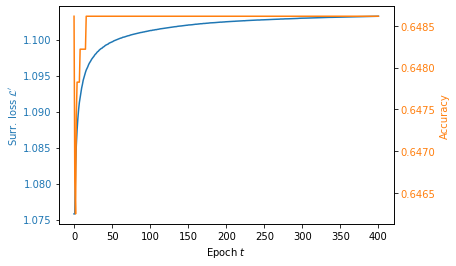

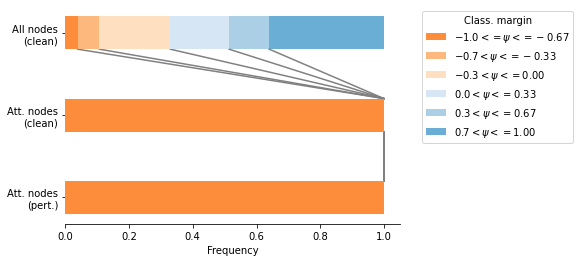

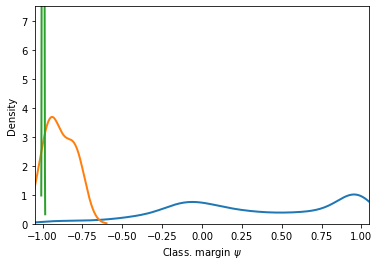

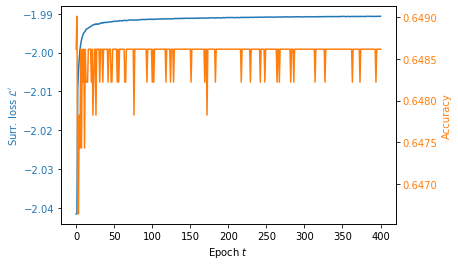

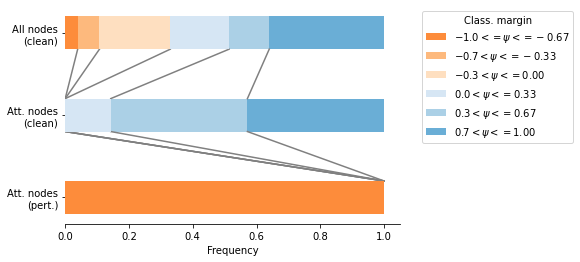

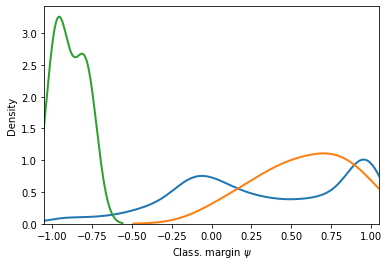

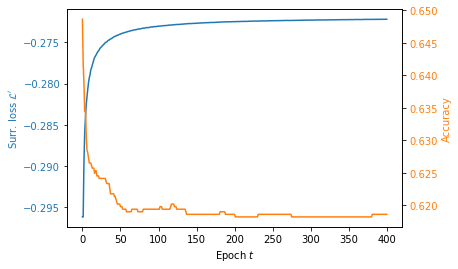

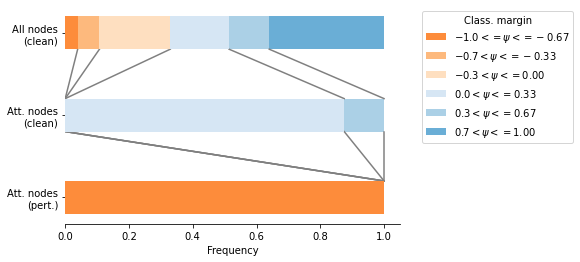

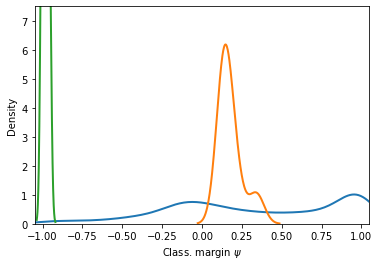

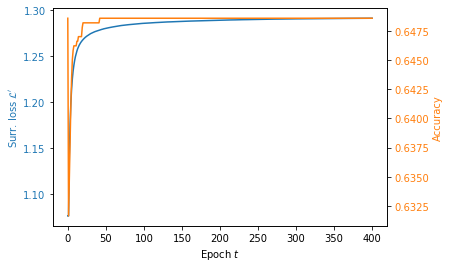

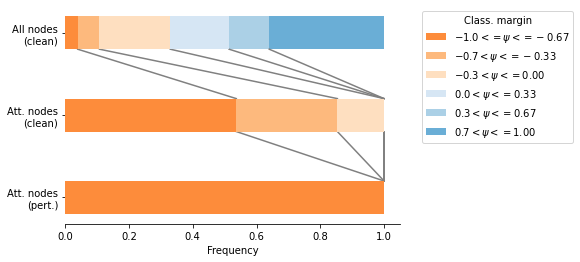

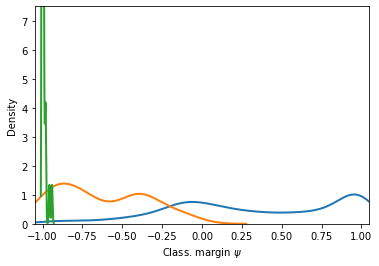

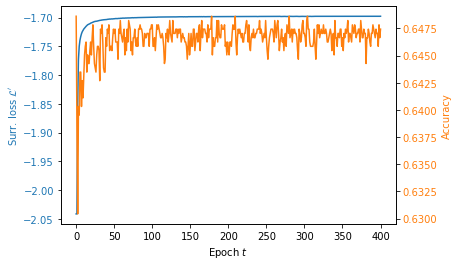

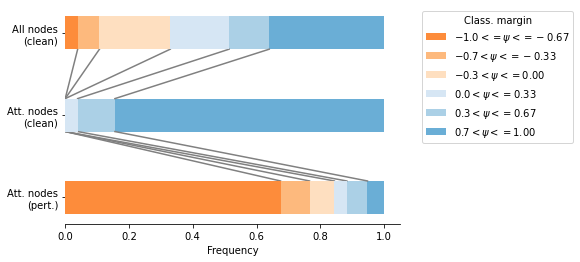

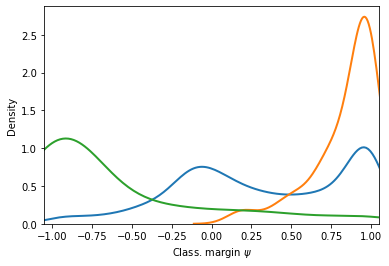

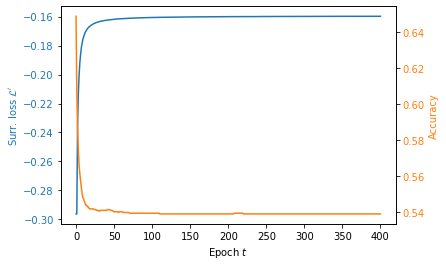

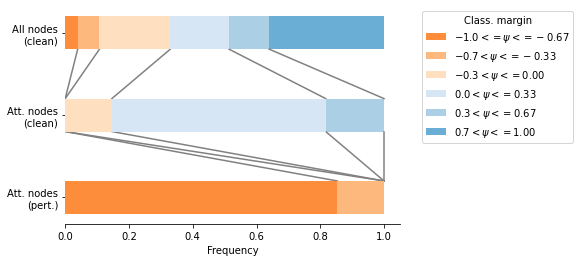

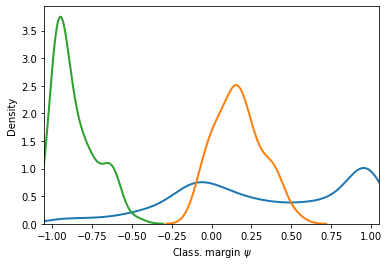

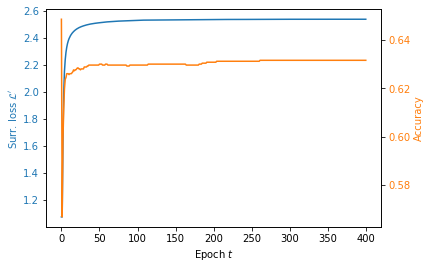

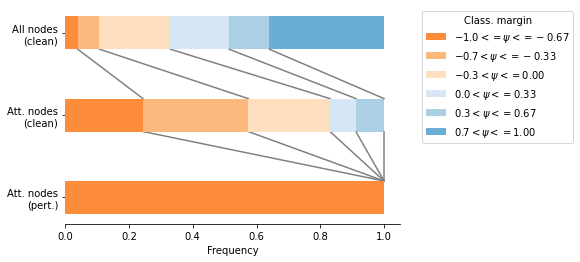

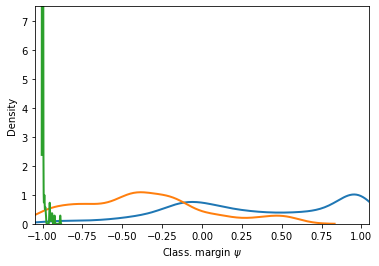

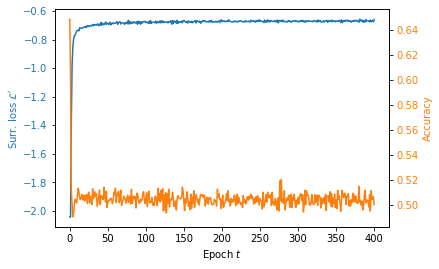

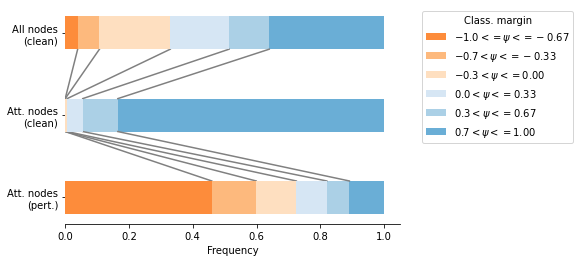

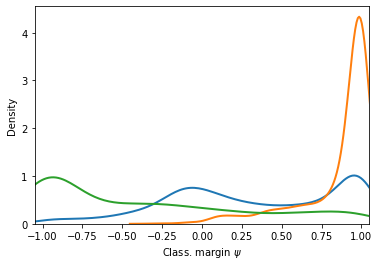

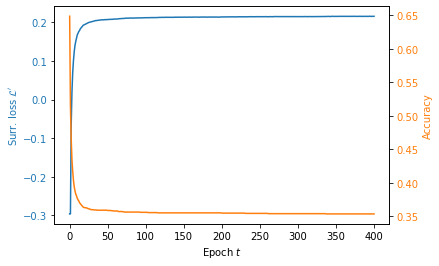

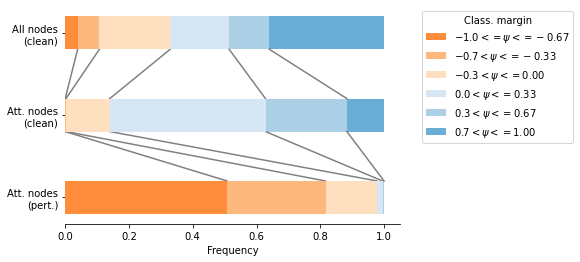

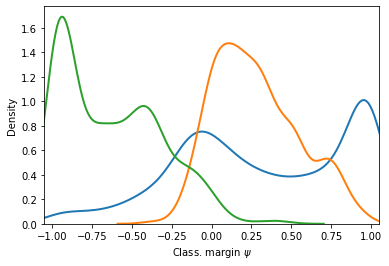

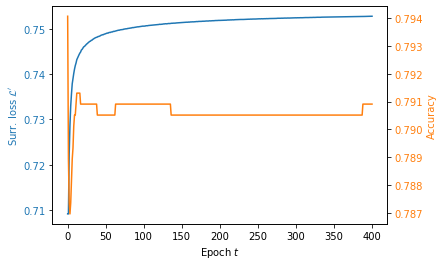

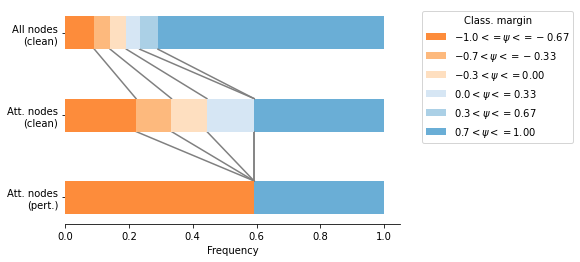

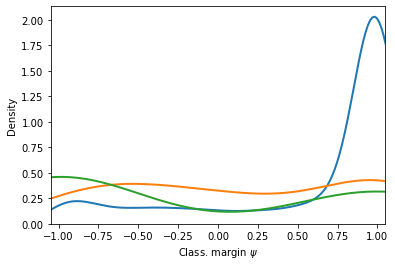

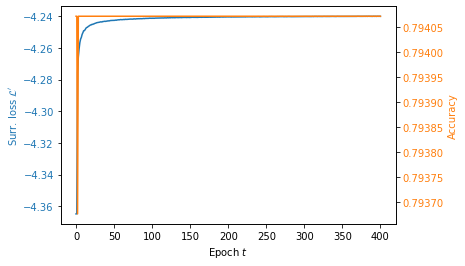

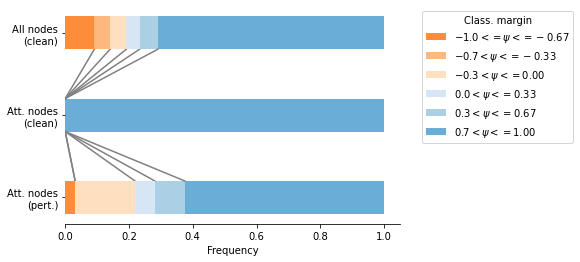

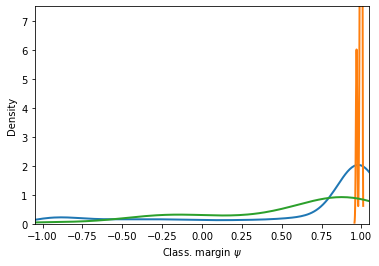

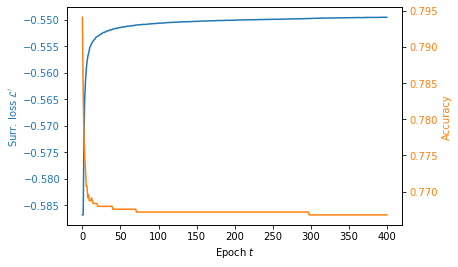

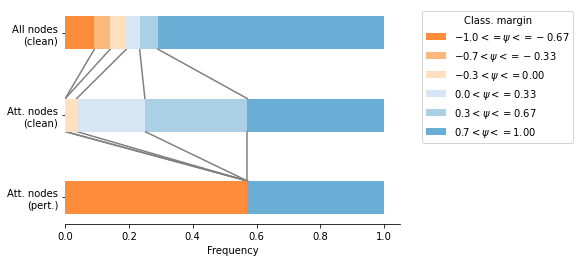

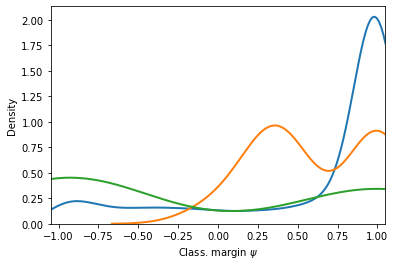

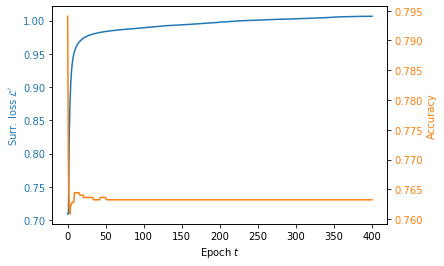

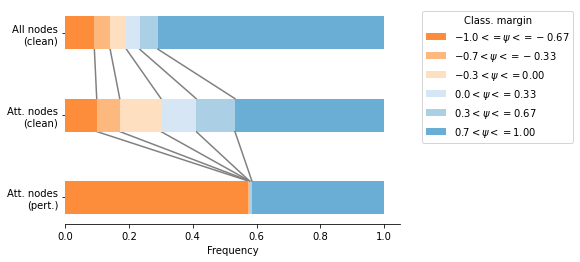

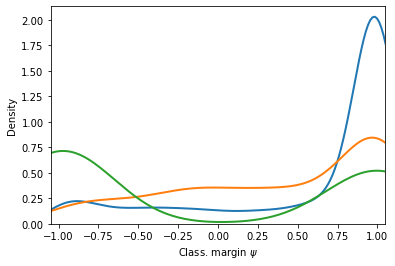

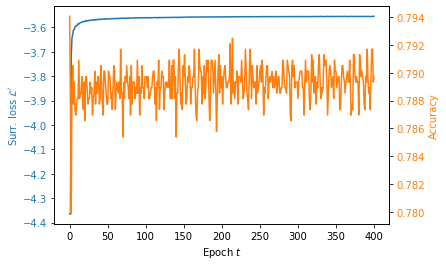

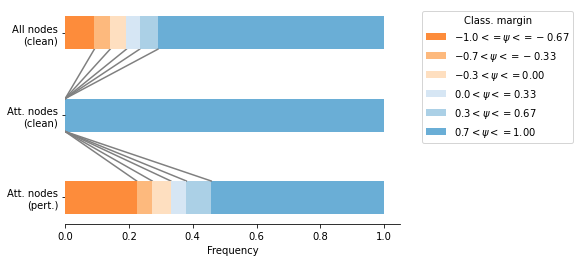

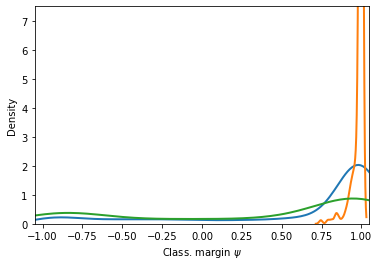

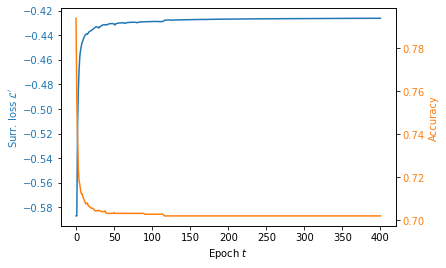

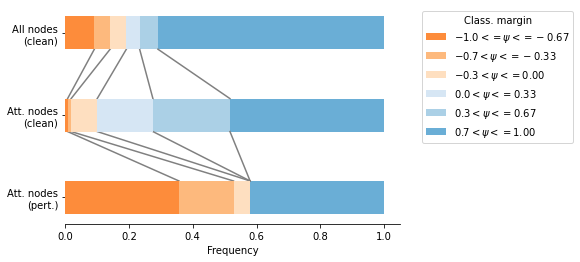

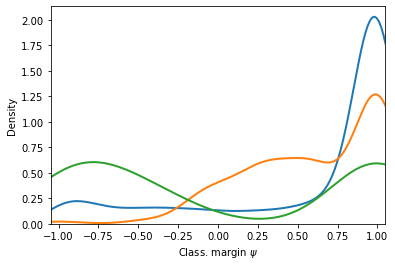

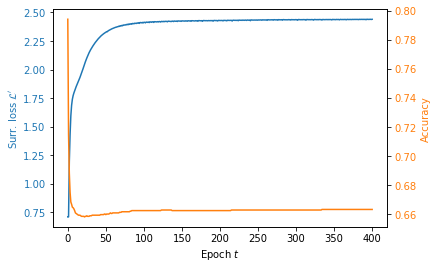

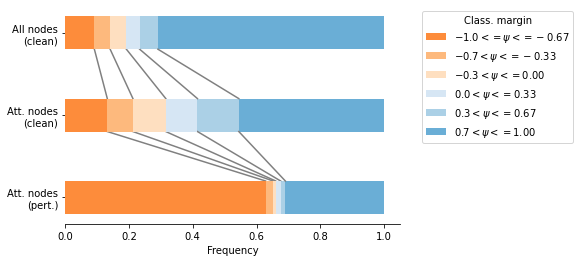

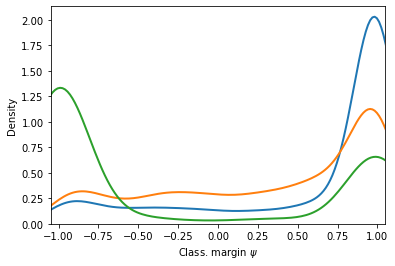

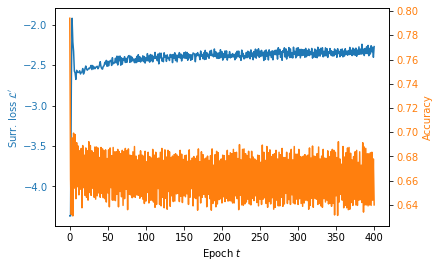

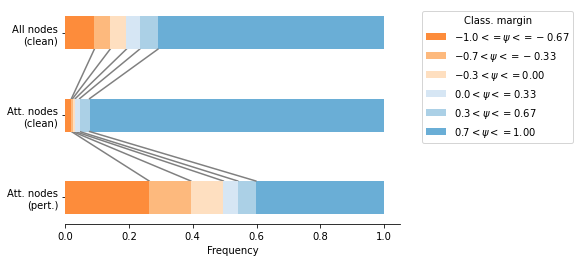

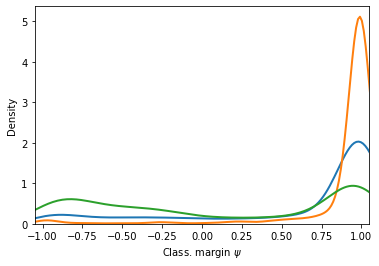

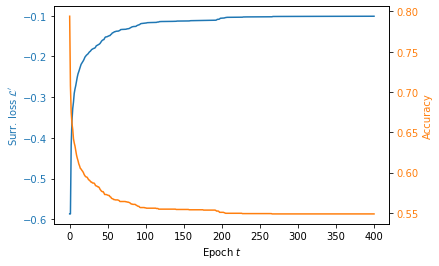

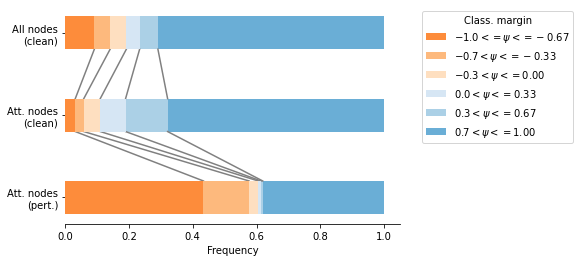

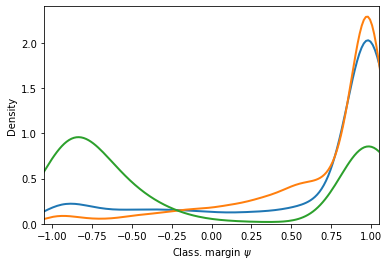

In [7]:
for dataset, search_space_size, victim_params in zip(datasets, search_space_sizes, victim_param_list):
    for make_undirected in [False, True]:
        print(dataset, search_space_size, victim_params, make_undirected)

        graph = prep_graph(dataset, device='cpu', binary_attr=binary_attr, make_undirected=make_undirected,
                           return_original_split=dataset.startswith('ogbn'))
        
        attr, adj, labels = graph[:3]
        if len(graph) == 3:
            idx_train, idx_val, idx_test = split(labels.cpu().numpy())
        else:
            idx_train, idx_val, idx_test = graph[3]['train'], graph[3]['valid'], graph[3]['test']
            
        n_features = attr.shape[1]
        n_classes = int(labels.max() + 1)

        victim_params_current = dict(victim_params)
        if make_undirected == False:
            victim_params['row_norm'] = True
            victim_params_current['n_filters'] = []

        gcn = GCN(n_classes=n_classes, n_features=n_features, **victim_params_current).to(device)
        train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
              idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **train_params)

        gcn.eval()

        with torch.no_grad():
            clean_logits = gcn(attr.to(device), adj.to(device))
        accuracy(clean_logits, labels.to(device), idx_test)
        print(f'Clean accuracy: {accuracy(clean_logits, labels.to(device), idx_test)}')

        for epsilon in epsilons:
            for loss_type in loss_types:
                print(dataset, make_undirected, epsilon, loss_type)
                
                temp_attack_params = dict(attack_params)
                temp_attack_params['loss_type'] = loss_type
                temp_attack_params['epsilon'] = epsilon
                temp_attack_params['search_space_size'] = search_space_size
                
                adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels, 
                                          make_undirected=make_undirected, model=gcn, idx_attack=idx_test, 
                                          device=device, data_device=device, **temp_attack_params)

                m = adj.nnz()
                torch.manual_seed(seed)
                np.random.seed(seed)

                n_perturbations = int(round(epsilon * m))
                adversary.attack(n_perturbations)
                
                ############## Attack Loss ###############
                
                fig, ax = plt.subplots()

                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
                ax.set_xlabel('Epoch $t$')
                ax.set_ylabel(r"Surr. loss $\mathcal{L}'$", color=color)
                ax.plot(adversary.attack_statistics['loss'], color=color)
                ax.tick_params(axis='y', labelcolor=color)

                ax = ax.twinx()

                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                ax.set_ylabel('Accuracy', color=color)
                ax.plot(adversary.attack_statistics['accuracy'], color=color)
                ax.tick_params(axis='y', labelcolor=color)
                
                plt.gcf().show()
                
                ############################################

                if make_undirected:
                    attcked_edges = adversary.modified_edge_index[
                        :, adversary.modified_edge_weight_diff.round().bool()
                    ].flatten()
                else:
                    attcked_edges = adversary.modified_edge_index[
                        0, adversary.modified_edge_weight_diff.round().bool()
                    ].flatten()
                attcked_edges = attcked_edges[np.isin(attcked_edges.cpu().numpy(), idx_test)]

                with torch.no_grad():
                    attacked_logits = gcn(attr.to(device), adversary.adj_adversary.to(device))
                print(f'Perturbed accuracy: {accuracy(attacked_logits, labels.to(device), idx_test)}')

                sorted_attacked = attacked_logits.argsort(-1).cpu()
                best_non_target_class_attacked = sorted_attacked[sorted_attacked != labels[:, None]].reshape(attacked_logits.size(0), -1)[:, -1]
                margin_attacked = (
                    F.softmax(attacked_logits, dim=-1)[np.arange(attacked_logits.size(0)), labels.long()]
                    - F.softmax(attacked_logits, dim=-1)[np.arange(attacked_logits.size(0)), best_non_target_class_attacked.long()]
                )

                sorted_clean = clean_logits.argsort(-1).cpu()
                best_non_target_class = sorted_clean[sorted_clean != labels[:, None]].reshape(clean_logits.size(0), -1)[:, -1]
                margin = (
                    F.softmax(clean_logits, dim=-1)[np.arange(clean_logits.size(0)), labels.long()]
                    - F.softmax(clean_logits, dim=-1)[np.arange(clean_logits.size(0)), best_non_target_class.long()]
                )

                freq_all_clean, borders = np.histogram(margin.cpu(), bins=bins, range=(-1,1), density=True)
                freq_attacked_clean, _ = np.histogram(margin[attcked_edges].cpu(), bins=bins, range=(-1,1), density=True)
                freq_attacked_pert, _ = np.histogram(margin_attacked[attcked_edges].cpu(), bins=bins, range=(-1,1), density=True)

                freq_all_clean = 2 / bins * np.cumsum(freq_all_clean)
                freq_attacked_clean = 2 / bins * np.cumsum(freq_attacked_clean)
                freq_attacked_pert = 2 / bins * np.cumsum(freq_attacked_pert)

                ############## Bar Plot ###############
                
                fig, ax = plt.subplots()

                for i, (el_0, el_1, el_2, color) in enumerate(zip(freq_all_clean, freq_attacked_clean, freq_attacked_pert, colors)):
                    if i != 0:
                        sep = '<'
                    else:
                        sep = '<='
                    plt.barh([x_0, x_1, x_2],
                             (el_0, el_1, el_2), 
                             bar_width,
                             color=color,
                             zorder=bins - i,
                             label=f'${borders[i]:.1f} {sep} \psi <= {borders[i + 1]:.2f}$')
                    if i < bins-1:
                        plt.plot((el_0, el_1), [x_0 - bar_width / 2, x_1 + bar_width / 2], color='grey', label='_nolegend_')
                        plt.plot((el_1, el_2), [x_1 - bar_width / 2, x_2 + bar_width / 2], color='grey', label='_nolegend_')

                plt.yticks([x_0, x_1, x_2], ['All nodes\n(clean)', 'Att. nodes\n(clean)', 'Att. nodes\n(pert.)'])

                plt.grid(False)

                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['top'].set_visible(False)

                plt.xlabel('Frequency')
                plt.legend(bbox_to_anchor=(1.05, 1), title=r'Class. margin', loc='upper left')

                plt.gcf().show()
                
                ############################################
                
                ############## KDE Plot ###############
                
                fig, ax = plt.subplots()

                kde1 = sns.kdeplot(margin.cpu().numpy(), ax=ax, label='Test nodes (clean)', linewidth=2)
                kde2 = sns.kdeplot(margin[attcked_edges].cpu().numpy(), ax=ax, label='Att. nodes (clean)', linewidth=2)
                kde3 = sns.kdeplot(margin_attacked[attcked_edges].cpu().numpy(), ax=ax, label='Att. nodes (pert.)', linewidth=2) #, 
                                   #color=kde2.lines[-1].get_color(), linestyle='--') # FOR CAMERA READY


                plt.xlim(-1.05, 1.05)
                plt.xlabel('Class. margin $\psi$')
                
                if ax.get_ylim()[1] > y_kde_max:
                    ax.set_ylim(0, y_kde_max)
                
                ############################################